In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import gridspec

xr.set_options(keep_attrs=True)


## Init dataset
dimension:
- time (01/01/2000 until from 01/12/2020)

In [2]:
time = pd.date_range(
        "01/2000",
        periods=20*12,
        freq=pd.DateOffset(months=1),
    )

amoc_dataset = xr.Dataset(
    data_vars=dict(),
    coords=dict(
        time=(["time"],time),
    ),
    attrs=dict(
        description="Aptherm Group Project to calculate the AMOC strength"
        ),
)


## Load datasets from all groups and adjust dimension names

In [3]:
DATAFOLDER = "data"

def RenameDimensionsAndVariables(dataset, dims_dict = dict(), vars_dict = False) :
    try:
        # rename the dimensions
        dataset = dataset.rename_dims(dims_dict)
        # rename coords assosiatet with dimensions
        try :
            dataset = dataset.rename_vars(dims_dict)
        except Exception as E :
            print(E)
        # rename the variables if necessary
        if vars_dict :
            dataset = dataset.rename_vars(vars_dict)
        return dataset
    except Exception as E :
        print(E)
        return None

# ============
# HYDROLOGICAL 
# group 1 and 2
hydrographic_mean = xr.open_dataset(DATAFOLDER + "/group1_mean_transport.nc")
hydrographic_mean = RenameDimensionsAndVariables(
            dataset = hydrographic_mean,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_mean"
                ))

hydrographic_climatology = xr.open_dataset(DATAFOLDER + "/group1_climatology_transport.nc")
hydrographic_climatology = RenameDimensionsAndVariables(
            dataset = hydrographic_climatology,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                TIME = "month"
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_climatology"
                ))

hydrographic_variability = xr.open_dataset(DATAFOLDER + "/group2_variability_interior_transport.nc")
hydrographic_variability = RenameDimensionsAndVariables(
            dataset = hydrographic_variability,
            dims_dict= 
            dict(
                lon = "longitude",
                p = "pressure",
            )
            )

# ============
# western boundary current
# group 3
western_boundary = xr.open_dataset(DATAFOLDER + "/group3_western_boundary_transport.nc")
western_boundary_monthly = western_boundary.resample(time="1MS").mean(dim="time")
western_boundary_monthly_std = western_boundary.resample(time="1MS").std(dim="time")

# ============
# ekman transport
# group 5
ekman_transport = xr.open_dataset(DATAFOLDER + "/group5_ekmann_transport.nc")

### Insert monthly ekman transport in Sv into the amoc dataset

In [4]:
amoc_dataset["ekman_transport"] = (1e-6*ekman_transport.volume_transport_y).where(ekman_transport.atlantic_mask).mean("latitude").sum('longitude')
amoc_dataset.ekman_transport.attrs = {
    ** ekman_transport.volume_transport_y.attrs,
    ** dict(
        long_name = 'ekman transport',
        label = 'ekman')
    }

### Create mean and std monthly transport of western boundary current

In [5]:
''' insert ekman_transport in Sv and westernboundary current to amoc dataset '''
western_boundary_attrs = dict(
    latitude = "11 deg S",
    longitude = "36 deg W - 34.8 deg W",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
)
''' For the mean of the Western boundary transport it only makes a minor difference when to resample'''
print('Total difference in mean western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").mean(dim="time") + western_boundary.Transport_neg.resample(time="1MS").mean(dim="time"))
            ).values
        )
    )

'''No need for the single pos and neg. transport'''
# amoc_dataset['western_boundary_pos'] = western_boundary.Transport_pos.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_pos.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil current in the upper layer towards the north",
#                 label = "Western boundary pos."
#                 )}

# amoc_dataset['western_boundary_neg'] = western_boundary.Transport_neg.resample(time="1MS").mean(dim="time")
# amoc_dataset.western_boundary_neg.attrs = {
#         **western_boundary_attrs,
#         **dict(description = "Western boundary transport of the Brazil under current in the lower layer towards the south",
#                 label = "Western boundary transport south"
#                 )}

amoc_dataset['western_boundary'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").mean(dim="time")
amoc_dataset.western_boundary.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport at 11 deg S",
                long_name = "Western boundary transport total",
                label = "WBT total"
                )}

'''regarding the std of the western boundary current there needs to be defined how to calulate it'''


print('Total difference in std of western boundary transport between adding before - after resample \n{:.3f} Sv'.format( 
        np.sum(( 
            western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time="1MS").std(dim="time") 
            - (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
            ).values
        )
    )
print('''regarding the std of the western boundary current there needs to be defined how to calulate it''')

# it is sufficient to calculate the standard deviation based on the combined transport, as they were both derived from the same dataset and are independent of each other.
# Thus the total std. is calc. after adding both.
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time= "1MS").std("time")
amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos.resample(time="1MS").std(dim="time") + western_boundary.Transport_neg.resample(time="1MS").std(dim="time"))
amoc_dataset.western_boundary_std.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport monthly standard deviation from daily to monthly mean calculation",
                long_name = "Western boundary transport std",
                label = "WBT std"
                )}


Total difference in mean western boundary transport between adding before - after resample 
-0.178 Sv
Total difference in std of western boundary transport between adding before - after resample 
-108.315 Sv
regarding the std of the western boundary current there needs to be defined how to calulate it


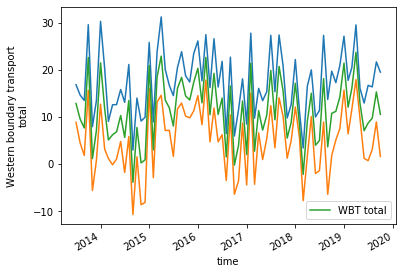

In [6]:
# quick plot of the western boundary transport
(amoc_dataset.western_boundary + amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary - amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary ).plot(label = amoc_dataset.western_boundary.attrs["label"])
plt.legend()


## Interior transport
1. add interior variability to the amoc dataset
2. calc interior mean from group1 and use it for amoc dataset

In [80]:
interior_attrs = dict(
    latitude = "11 deg S",
    longitude = "34.8 deg W to 12.5°E",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
    )

'''determine that hydrographic_variablity wont be changed when transforming from mid of month to beginning of month'''
print(
    "The difference of interior variability before and after resample:\n{:.3f} Sv".format(
        np.sum(hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time").values - hydrographic_variability.integrated_transport.values)
    )
)
amoc_dataset['interior_variability'] = hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time")
amoc_dataset.interior_variability.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport variability",
                    label = "Interior var.",
                    )
                }

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['interior_mean'] = 13.8 + 0*hydrographic_variability.integrated_transport.resample(time = "1MS").mean("time")
amoc_dataset.interior_mean.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport mean",
                    label = "Interior mean"
                    )
                }

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['interior'] = amoc_dataset.interior_variability + amoc_dataset.interior_mean
amoc_dataset.interior.attrs = {**hydrographic_variability.integrated_transport.attrs,
                **interior_attrs,
                **dict(
                    long_name = "Interior transport variablility plus mean",
                    label = "Interior"
                    )
                }


The difference of interior variability before and after resample:
0.000 Sv


## calculate total transport 

In [95]:
# to combine the missing data it might help to combine with nans replaced by zeros or whatever
replace_nan_with_other = lambda data, x= np.nan : data.where(~np.isnan(data), other = x)
''' need to decide how to handle the missing WBC data '''

# 2. add mean interior from group 1 to amoc dataset
amoc_dataset['total'] = replace_nan_with_other(amoc_dataset.interior) + \
                        replace_nan_with_other(amoc_dataset.ekman_transport) + \
                        replace_nan_with_other(amoc_dataset.western_boundary)
amoc_dataset.interior.attrs = {
                **dict(
                    unit = "Sv",
                    long_name = "Interior transport variablility plus mean",
                    label = "Interior"
                    )
                }

## Create a temporal plot and a seasonal cyle plot

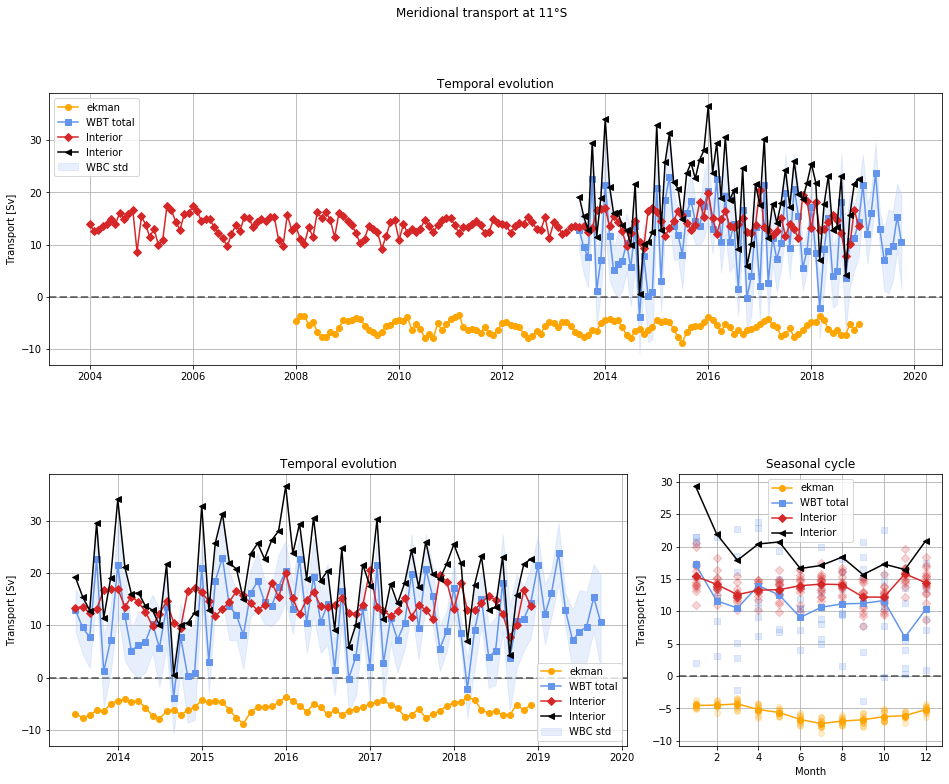

In [131]:
def plot_timeseries(data, ax, kwargs = dict()) :
    
    # use the passed kwarg label for all the plots
    if "label" in kwargs:
        pass
    else :
        kwargs["label"] = data.attrs["label"]

    ax.plot(
            data.time,
            data.values,
            alpha=1, zorder = 10,
            **kwargs
            )

def plot_seasonalcycle(data, ax, kwargs = dict(), scatter_plot = True):

    # use the passed kwarg label for all the plots
    if "label" in kwargs:
        pass
    else :
        kwargs["label"] = data.attrs["label"]
    
    # for the second axes object plot for each of the transport the seasonal cyle and for each month all the values as scatters
    ax.plot(
            data.groupby("time.month").mean("time").month, 
            data.groupby("time.month").mean("time").values,
            alpha=1, zorder = 10,
            **kwargs
            )
    # delete label for the scatter plot
    kwargs.pop("label")
    # only plot the scatter for each year if wanted:
    if scatter_plot is True:
        for year in np.unique(amoc_dataset.time.dt.year.values) :
            ax.scatter(data.time.dt.month.values, 
                        data.where(data.time.dt.year == year).values,
                        alpha=0.2, zorder = 10,
                        **kwargs)

def plot_std(data, data_std, ax, kwargs = dict()):
    # use the passed kwarg label for all the plots
    if "label" in kwargs:
        pass
    else :
        kwargs["label"] = data.attrs["label"]

    ax.fill_between(
            x = data.time,
            y1 = (data - data_std).values,
            y2 = (data + data_std).values,
            alpha=0.3, zorder = 5,
            **kwargs
            )

def plot_data(data, ax1, ax2, kwargs = dict(), scatter_plot = True):
    plot_timeseries(data, ax1, kwargs = kwargs)
    plot_seasonalcycle(data, ax2, kwargs = kwargs, scatter_plot = scatter_plot)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


fig = plt.figure(figsize= (16,12))
gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 2])
ax3 = fig.add_subplot(gs[1, 0:2])

colors = ("orange", "cornflowerblue", "tab:red", "k")
markers = ('o', 's', 'D', '<', '>', 'p')
idx = 0

# ---- EKMAN ----
plot_data(amoc_dataset.ekman_transport, 
            ax1 = ax1, ax2 = ax2, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )

# ---- WESTERN BOUNDARY ----
idx += 1
plot_data(amoc_dataset.western_boundary, 
            ax1 = ax1, ax2 = ax2, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )
#also plot std of western boundary current
plot_std(data = amoc_dataset.western_boundary, data_std = amoc_dataset.western_boundary_std, 
            ax = ax1,
            kwargs= dict(
                        # alpha = 0.2,
                        label = "WBC std",
                        color = lighten_color(colors[idx], amount = 0.5),
                        )
            )

# ---- INTERIOR ----
idx += 1
plot_data(amoc_dataset.interior, 
            ax1 = ax1, ax2 = ax2, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )

# ---- FULL ----
idx += 1
plot_data(amoc_dataset.total, 
            ax1 = ax1, ax2 = ax2,
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        ),
            scatter_plot= False
            )



ax1.grid()
ax1.set_title("Temporal evolution")
ax1.set_xlabel(None)
ax1.set_ylabel("Transport [Sv]")
ax1.legend()

ax2.grid()
ax2.set_title("Seasonal cycle")
ax2.set_xlabel("Month")
ax2.set_ylabel("Transport [Sv]")
ax2.legend()

''' plot the zoomed ax1^: '''
# find first and last valid index of the total timeseries:
first_valid_time = pd.Series.first_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.western_boundary)).to_pandas())
last_valid_time =pd.Series.last_valid_index(amoc_dataset.time.where(~np.isnan(amoc_dataset.western_boundary)).to_pandas())
idx = 0



# ---- EKMAN ----
plot_timeseries(amoc_dataset.ekman_transport.sel(time = slice(first_valid_time, last_valid_time)), 
            ax = ax3, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )

# ---- WESTERN BOUNDARY ----
idx += 1
plot_timeseries(amoc_dataset.western_boundary.sel(time = slice(first_valid_time, last_valid_time)),
            ax = ax3, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )
#also plot std of western boundary current
plot_std(data = amoc_dataset.western_boundary.sel(time = slice(first_valid_time, last_valid_time)), data_std = amoc_dataset.western_boundary_std.sel(time = slice(first_valid_time, last_valid_time)), 
            ax = ax3,
            kwargs= dict(
                        # alpha = 0.2,
                        label = "WBC std",
                        color = lighten_color(colors[idx], amount = 0.5),
                        )
            )

# ---- INTERIOR ----
idx += 1
plot_timeseries(amoc_dataset.interior.sel(time = slice(first_valid_time, last_valid_time)), 
            ax = ax3, 
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )

# ---- FULL ----
idx += 1
plot_timeseries(amoc_dataset.total.sel(time = slice(first_valid_time, last_valid_time)), 
            ax = ax3,
            kwargs= dict(
                        color = colors[idx], 
                        marker = markers[idx]
                        )
            )

ax3.grid()
ax3.set_title("Temporal evolution")
ax3.set_xlabel(None)
ax3.set_ylabel("Transport [Sv]")
ax3.legend()

# ax3.set_ylim([first_valid_time, last_valid_time])
fig.suptitle("Meridional transport at 11°S")

for axs in [ax1,ax2, ax3] :
    axs.axhline(0, linestyle = "--", linewidth = 2, color = "k", alpha = 0.5, zorder = 2)

# fig.savefig(PLOTFOLDER + "11S_Transport.svg") #, dpi = 400)

In [54]:
lighten_color(colors[idx], amount = 0.5)

(0.6960784313725489, 0.7921568627450979, 0.9647058823529412)

Timestamp('2019-10-01 00:00:00', freq='<DateOffset: months=1>')

AttributeError: 'AxesSubplot' object has no attribute 'copy'

<Figure size 432x288 with 0 Axes>

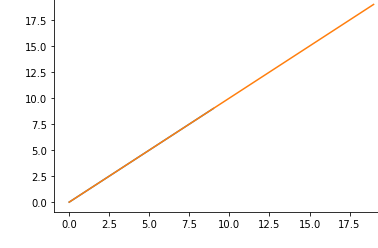

In [125]:
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()
ax.plot(range(10))
ax.remove()
ax.plot(range(20))
fig2 = plt.figure()
ax.figure=fig2
fig2.axes.append(ax)
fig2.add_axes(ax)
ax2 = ax.copy()
dummy = fig2.add_subplot(111)
ax.set_position(dummy.get_position())
dummy.remove()
plt.close(fig1)

fig2.show()